## Data Cleaning
We prepared the dataset for analysis by parsing dates, setting the index, removing duplicates, and filling or correcting missing values in price and volume data.

**1. Load and preprocess dataset**  

Imported Pandas and NumPy, loaded the CSV file, parsed the 'Date' column into datetime format, set it as the index, sorted chronologically, and dropped duplicate entries to ensure data integrity.

In [24]:
import pandas as pd
import numpy as np

df = pd.read_csv("/workspaces/python-for-finance-bobby-zlatarov/DASH.csv")
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
df = df.set_index("Date").sort_index().drop_duplicates()

**2. Add previous close and fill missing 'Open' and 'Close' values**  

Used `.shift(1)` to create a 'Prev_Close' column, then filled missing 'Open' prices using the previous close. Missing 'Close' values were forward-filled using `.ffill()`.

In [25]:
df["Prev_Close"] = df["Close"].shift(1)
df["Open"] = df["Open"].fillna(df["Prev_Close"])
df["Close"] = df["Close"].ffill()

**3. Fill missing 'High' and 'Low' prices using monthly averages** 
 
Grouped by month and filled missing 'High' and 'Low' values with the monthly mean to preserve realistic price ranges without forward-filling from unrelated periods.

In [26]:
df["High"] = df["High"].fillna(df.groupby(df.index.to_period("M"))["High"].transform("mean"))
df["Low"] = df["Low"].fillna(df.groupby(df.index.to_period("M"))["Low"].transform("mean"))

**4. Handle missing 'Volume' values**  

Set 'Volume' to 0 if it was missing **and** the stock didn't move (Open = Close). For all other missing volume entries, replaced with the median volume.

In [27]:
df.loc[df["Volume"].isna() & (df["Close"] == df["Open"]), "Volume"] = 0

vol_median = df["Volume"].median()
mask = df["Volume"].isna() & (df["Close"] != df["Open"])
df.loc[mask, "Volume"] = vol_median

## Feature Engineering

**1. Simple Day Returns**  

Calculated daily percentage changes using `.pct_change()` on closing prices. This captures short-term price movements and is a basic input for return-based financial analysis.

In [28]:
df["Simple_Return"] = df.Close.pct_change()

**2. Logarithmic Returns**  

Computed log returns with `np.log(Close / Prev_Close)`. These are time-additive and better suited for statistical models and long-term performance evaluation than simple returns.



In [29]:
df["Log_Return"] = np.log(df["Close"] / df["Prev_Close"])

**3. 20-Day Momentum**  

Used `.shift(20)` to compare today’s price to that of 20 trading days ago. Captures medium-term momentum and helps assess trend strength over recent periods.

In [30]:
df["20D_Momentum"] = df["Close"] - df["Close"].shift(20)

**4. 20-Day Simple Moving Average**
  
Applied `.rolling(window=20).mean()` to smooth out noise in daily prices. This trend-following indicator highlights the direction and persistence of recent price movements.

In [31]:
df["20D_SMA"] = df["Close"].rolling(window=20).mean()

**5. 20-Day Rolling Volatility**  

Calculated the standard deviation of daily returns in a 20-day window to quantify recent price volatility, which is commonly used to assess risk and market uncertainty.

In [32]:
df["Dev"] = df["Close"].rolling(window=20).std()

**6. Day of the Week**  

Extracted the weekday from the index using `.day_name()` to explore systematic patterns in returns across different weekdays, such as the Monday or Friday effect.

In [ ]:
df["Day_of_Week"] = df.index.day_name()


/tmp/ipykernel_3131/3882785312.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Day_of_Week"] = df.index.day_name()


,Close,High,Low,Open,Volume,Prev_Close,Simple_Return,Log_Return,20D_Momentum,20D_SMA,Dev,Day_of_Week,Price_Surge,Volume_Spike,Upper_BB,Lower_BB
Date,,,,,,,,,,,,,,,,
2021-01-07,152.770004,154.639999,139.434998,140.000000,3215200.0,140.009995,0.091136,0.087220,NaN,156.511000,14.395864,Thursday,False,False,185.302729,127.719271
2021-01-08,156.089996,158.309998,147.300003,152.000000,2548700.0,152.770004,0.021732,0.021499,-33.419998,154.840000,12.124304,Friday,False,False,179.088608,130.591392
2021-01-11,167.000000,169.000000,153.190002,153.190002,2541300.0,156.089996,0.069896,0.067561,-19.000000,153.890000,10.135519,Monday,False,False,174.161038,133.618962
2021-01-12,191.990005,201.929993,162.615005,165.500000,7081800.0,167.000000,0.149641,0.139450,16.990005,154.739500,12.446499,Tuesday,True,False,179.632499,129.846502
2021-01-13,191.990005,215.500000,188.070007,192.410004,6058800.0,191.990005,0.000000,0.000000,31.990005,156.339001,14.959860,Wednesday,False,False,186.258720,126.419281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-09,217.490005,219.830002,216.955002,218.029999,2710300.0,218.449997,-0.004395,-0.004404,33.970001,206.409998,7.886279,Monday,False,False,222.182556,190.637440
2025-06-10,214.970001,219.210007,210.927002,216.589996,3916700.0,217.490005,-0.011587,-0.011654,22.869995,207.553498,7.341377,Tuesday,False,False,222.236252,192.870744
2025-06-11,217.800003,219.529999,212.240005,214.184998,3091500.0,214.970001,0.013165,0.013079,20.000000,208.553498,7.304940,Wednesday,False,False,223.163377,193.943619


**7. Price Surge Identification**  

Identified large price movements by flagging daily returns exceeding 4 standard deviations above the mean. This helps detect unusual spikes possibly linked to news or market events.

In [ ]:
#mean_return = df["Simple_Return"].mean()
#std_return = df["Simple_Return"].std()
#df["Price_Surge"] = df["Simple_Return"] > (mean_return + 4 * std_return)

df["Price_Surge"] = df.Simple_Return > df.Simple_Return.mean() + 4 * df.Simple_Return.std()


/tmp/ipykernel_3131/909803433.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_Surge"] = df["Simple_Return"] > (mean_return + 4 * std_return)
/tmp/ipykernel_3131/909803433.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_Surge"] = df.Simple_Return > df.Simple_Return.mean() + 4 * df.Simple_Return.std()


,Close,High,Low,Open,Volume,Prev_Close,Simple_Return,Log_Return,20D_Momentum,20D_SMA,Dev,Day_of_Week,Price_Surge,Volume_Spike,Upper_BB,Lower_BB
Date,,,,,,,,,,,,,,,,
2021-01-07,152.770004,154.639999,139.434998,140.000000,3215200.0,140.009995,0.091136,0.087220,NaN,156.511000,14.395864,Thursday,False,False,185.302729,127.719271
2021-01-08,156.089996,158.309998,147.300003,152.000000,2548700.0,152.770004,0.021732,0.021499,-33.419998,154.840000,12.124304,Friday,False,False,179.088608,130.591392
2021-01-11,167.000000,169.000000,153.190002,153.190002,2541300.0,156.089996,0.069896,0.067561,-19.000000,153.890000,10.135519,Monday,False,False,174.161038,133.618962
2021-01-12,191.990005,201.929993,162.615005,165.500000,7081800.0,167.000000,0.149641,0.139450,16.990005,154.739500,12.446499,Tuesday,True,False,179.632499,129.846502
2021-01-13,191.990005,215.500000,188.070007,192.410004,6058800.0,191.990005,0.000000,0.000000,31.990005,156.339001,14.959860,Wednesday,False,False,186.258720,126.419281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-09,217.490005,219.830002,216.955002,218.029999,2710300.0,218.449997,-0.004395,-0.004404,33.970001,206.409998,7.886279,Monday,False,False,222.182556,190.637440
2025-06-10,214.970001,219.210007,210.927002,216.589996,3916700.0,217.490005,-0.011587,-0.011654,22.869995,207.553498,7.341377,Tuesday,False,False,222.236252,192.870744
2025-06-11,217.800003,219.529999,212.240005,214.184998,3091500.0,214.970001,0.013165,0.013079,20.000000,208.553498,7.304940,Wednesday,False,False,223.163377,193.943619


**8. Volume Spike Identification**  

Flagged unusual trading activity by marking days when volume exceeds the mean by more than 6 standard deviations, which often signals abnormal investor behavior or significant events.

In [ ]:
#mean_volume = df["Volume"].mean()
#std_volume = df["Volume"].std()
df["Volume_Spike"] = df.Volume > df.Volume.mean() + 6 * df.Volume.std()

**9. Bollinger Bands Calculation**  

Computed Bollinger Bands using the 20-day SMA and rolling volatility. These define a volatility-based range to help spot overbought or oversold conditions in the price.

In [36]:
df["Upper_BB"] = df["20D_SMA"] + (2 * df["Dev"])
df["Lower_BB"] = df["20D_SMA"] - (2 * df["Dev"])

df

,Close,High,Low,Open,Volume,Prev_Close,Simple_Return,Log_Return,20D_Momentum,20D_SMA,Dev,Day_of_Week,Price_Surge,Volume_Spike,Upper_BB,Lower_BB
Date,,,,,,,,,,,,,,,,
2020-12-09,189.509995,195.500000,163.800003,182.000000,25373700.0,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday,False,False,NaN,NaN
2020-12-10,186.000000,187.695007,172.636002,179.710007,3506600.0,189.509995,-0.018521,-0.018695,NaN,NaN,NaN,Thursday,False,False,NaN,NaN
2020-12-11,175.000000,182.000000,168.250000,176.520004,4760600.0,186.000000,-0.059140,-0.060961,NaN,NaN,NaN,Friday,False,False,NaN,NaN
2020-12-14,160.000000,170.000000,151.199997,169.100006,7859600.0,175.000000,-0.085714,-0.089612,NaN,NaN,NaN,Monday,False,False,NaN,NaN
2020-12-15,158.889999,161.419998,153.759995,157.100006,5017000.0,160.000000,-0.006938,-0.006962,NaN,NaN,NaN,Tuesday,False,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-09,217.490005,219.830002,216.955002,218.029999,2710300.0,218.449997,-0.004395,-0.004404,33.970001,206.409998,7.886279,Monday,False,False,222.182556,190.637440
2025-06-10,214.970001,219.210007,210.927002,216.589996,3916700.0,217.490005,-0.011587,-0.011654,22.869995,207.553498,7.341377,Tuesday,False,False,222.236252,192.870744
2025-06-11,217.800003,219.529999,212.240005,214.184998,3091500.0,214.970001,0.013165,0.013079,20.000000,208.553498,7.304940,Wednesday,False,False,223.163377,193.943619


# Key Dates and Metrics

**1. Highest Rolling Volatility dates**

To identify the date and the value of the highest rolling volatility in each year, we are using the `groupby` function to group the data by the different years for which we also need the `to_period` function.

`df.dropna(subset=["Dev"])`:
Removes rows where the "Dev" (volatility) column is NaN, preventing errors and ensuring only valid data is considered for the maximum search.

`df.index.to_period("Y")`:
Converts the datetime index to a yearly period, so groupby groups by year.

`df.groupby(...["Dev"].idxmax()`:
For each year group, finds the index (date) where "Dev" is the maximum.

`df.loc[...,"Dev"]`:
Selects the rows at those dates and returns the "Dev" value for each year's maximum.


In [37]:
df = df.dropna(subset=["Dev"])

df.loc[df.groupby(df.index.to_period("Y"))["Dev"].idxmax(), "Dev"]

Date
2021-12-10    30.769827
2022-02-07    15.943753
2023-11-21     9.169464
2024-08-19    10.280160
2025-03-13    11.383797
Name: Dev, dtype: float64

**2. Largest Price Surge day**

`df.index.to_period("Y")` converts the datetime index to yearly periods.
This means each group contains all the rows (days) that belong to the same year.

For each year, it finds the index (date) where `Simple_Return` is the highest.
`idxmax()` returns the index label (the date) where the max value occurs within each group/year.

`df.loc[ ... , "Simple_Return"]` selects the rows in df where the index matches the dates found above, and returns only the `Simple_Return` for those rows.

In [38]:
df.loc[df.groupby(df.index.to_period("Y"))["Simple_Return"].idxmax(), "Simple_Return"]

Date
2021-05-14    0.221491
2022-03-16    0.134512
2023-11-02    0.156653
2024-08-02    0.083457
2025-04-09    0.137738
Name: Simple_Return, dtype: float64

**3. Largest Price Drop Day**

`df.groupby(df.index.to_period("Y"))`: Groups the data by year

`["Simple_Return"].idxmin()`: For each year, finds the date where `Simple_Return` is the lowest (most negative)

We use `idxmin()` instead of `idxmax()` because we want the largest price drop (most negative return)

In [54]:


df.loc[df.groupby(df.index.to_period("Y"))["Simple_Return"].idxmin(), "Simple_Return"]

Date
2021-02-22   -0.135457
2022-05-11   -0.131621
2023-02-17   -0.075946
2024-05-02   -0.103170
2025-04-03   -0.080634
Name: Simple_Return, dtype: float64

**4. Highest Volume Day**

`df.groupby(df.index.to_period("Y"))`: Groups the data by year

`["Volume"].idxmax()`: For each year, finds the date where Volume is the highest

In [40]:

df.loc[df.groupby(df.index.to_period("Y"))["Volume"].idxmax(), "Volume"]

Date
2021-03-09    20400000.0
2022-02-17    47405700.0
2023-12-15    30556000.0
2024-05-02    22134800.0
2025-03-21    73637400.0
Name: Volume, dtype: float64

**5. Highest High and Lowest Low**

`groupby(...)[“High”].idxmax()` finds, for each year, the index (i.e., date) where the “High” column is the highest.

`df.loc[ ... , ["High"]]` selects those rows and the “High” column, giving a DataFrame with the date as the index and the highest high value for each year.

`highs['High_Date'] = highs.index.strftime('%Y-%m-%d')` adds a column with the date (as a string) of each high.

Similar to above, but with `idxmin()` to find the date of the minimum (lowest) value in the “Low” column.



In [41]:
yearly_highs = df.groupby(df.index.to_period('Y'))['High'].idxmax()
yearly_lows = df.groupby(df.index.to_period('Y'))['Low'].idxmin()

highs = df.loc[yearly_highs, ['High']]
highs['High_Date'] = highs.index.strftime('%Y-%m-%d')

lows = df.loc[yearly_lows, ['Low']]
lows['Low_Date'] = lows.index.strftime('%Y-%m-%d')

result = pd.DataFrame({
    'High_Date': highs['High_Date'].values,
    'High': highs['High'].values,
    'Low_Date': lows['Low_Date'].values,
    'Low': lows['Low'].values
}, index=highs.index.to_period('Y'))

result.index.name = 'Year'

result = result[['High_Date', 'High', 'Low_Date', 'Low']]

print(result)


       High_Date        High    Low_Date         Low
Year                                                
2021  2021-11-15  257.250000  2021-05-13  110.129997
2022  2022-01-12  152.494995  2022-10-24   41.365002
2023  2023-12-11  103.980003  2023-01-06   45.931999
2024  2024-12-17  181.779999  2024-01-04   93.330002
2025  2025-06-06  220.880005  2025-04-07  155.399994


**6. Annual Open and Close**

`Open_Date=('Open', lambda x: x.index[0])`:
For the "Open" column, get the index (date) of the first value in each year (i.e., when the year’s opening price occurred).

`Open=('Open', 'first')`:
The opening price at the start of each year (same as before).

`Close_Date=('Close', lambda x: x.index[-1])`:
For the "Close" column, get the index (date) of the last value in each year (i.e., when the year’s closing price occurred).

`Close=('Close', 'last')`:
The closing price at the end of each year (same as before).

`lambda x` functions on the index will capture the specific dates associated with the prices

In [42]:
df.groupby(df.index.to_period('Y')).agg({"Open" : "first", "Close" : "last"})

df.groupby(df.index.to_period('Y')).agg(
    Open_Date=('Open', lambda x: x.index[0]),   
    Open=('Open', 'first'),                      
    Close_Date=('Close', lambda x: x.index[-1]),  
    Close=('Close', 'last')                      
)

,Open_Date,Open,Close_Date,Close
Date,,,,
2021,2021-01-07,140.000000,2021-12-31,148.899994
2022,2022-01-03,149.610001,2022-12-30,48.820000
2023,2023-01-03,49.980000,2023-12-29,98.889999
2024,2024-01-02,97.800003,2024-12-31,167.750000
2025,2025-01-02,168.789993,2025-06-13,218.119995


# Data Visualization 

**1. Close Prices, SMA and Bollinger Bands Plot**

Plotting the close prices along with the simple moving average line and Bollinger Bands.

/tmp/ipykernel_3131/3220064686.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


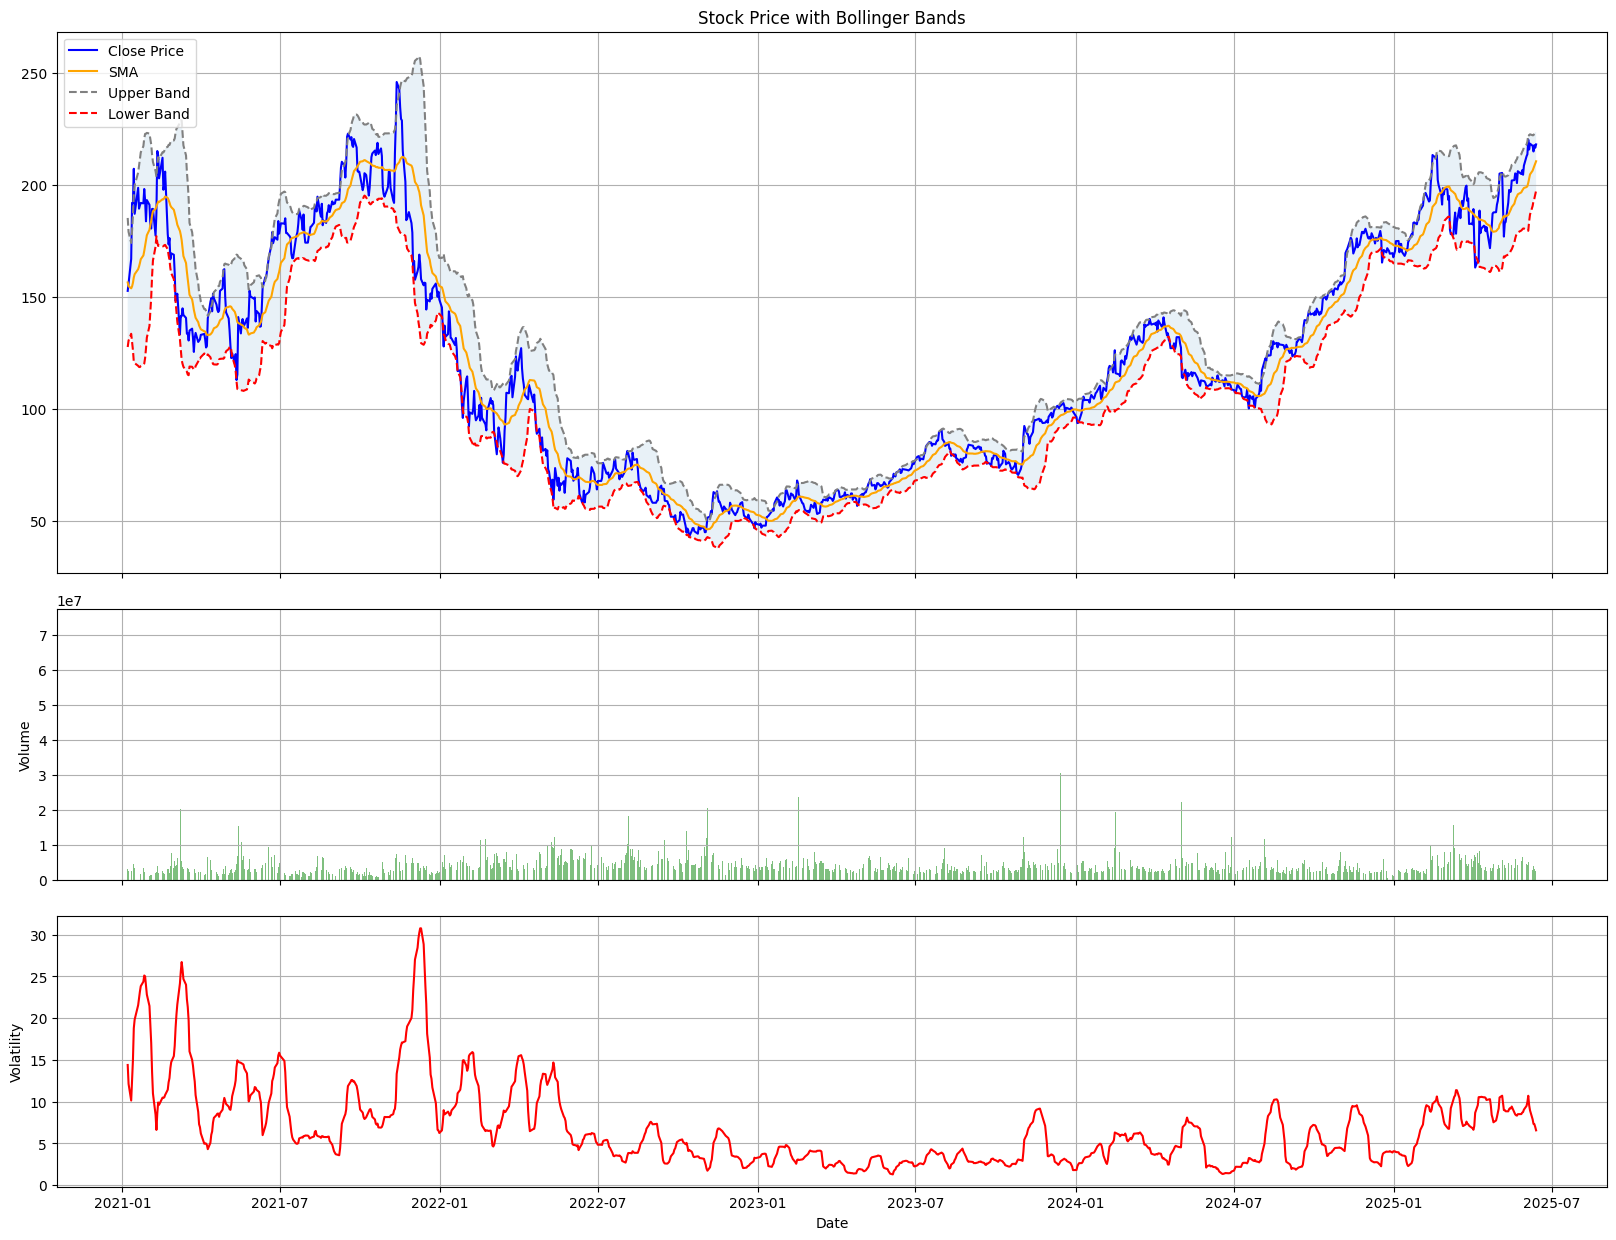

In [43]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

def plot_stock_analysis(df):
    fig, (ax1, ax2, ax3) = plt.subplots(
        nrows=3,
        ncols=1,
        figsize=(20, 15),
        sharex=True,       # This makes all x-axes the same (dates aligned)
        gridspec_kw={'height_ratios': [2, 1, 1], 'hspace': 0.1}
    )

    # Main price plot with Bollinger Bands and SMA
    ax1.plot(df.index, df['Close'], label='Close Price', color='blue')
    ax1.plot(df.index, df['20D_SMA'], label='SMA', color='orange')
    ax1.plot(df.index, df['Upper_BB'], label='Upper Band', color='gray', linestyle='--')
    ax1.plot(df.index, df['Lower_BB'], label='Lower Band', color='red', linestyle='--')
    ax1.fill_between(df.index, df['Upper_BB'], df['Lower_BB'], alpha=0.1)
    ax1.set_title('Stock Price with Bollinger Bands')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Volume subplot
    ax2.bar(df.index, df['Volume'], color='green', alpha=0.5)
    ax2.set_ylabel('Volume')
    ax2.grid(True)

    # Volatility subplot
    ax3.plot(df.index, df['Dev'], color='red')
    ax3.set_ylabel('Volatility')
    ax3.set_xlabel('Date')
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

plot_stock_analysis(df)

**2. Histograms of Log Returns**

Plot a histogram of log returns

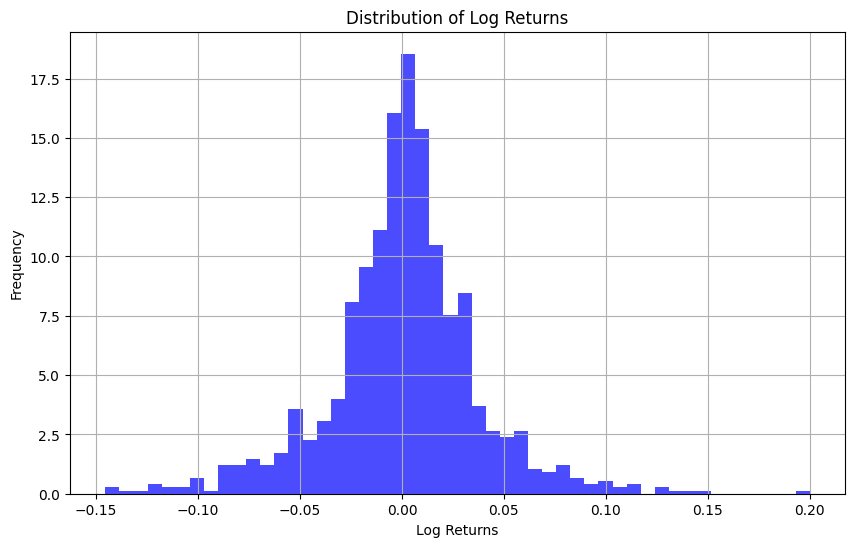

In [44]:
def plot_returns_histogram(df):
    plt.figure(figsize=(10, 6))
    plt.hist(df['Log_Return'].dropna(), bins=50, density=True, alpha=0.7, color='blue')
    plt.title('Distribution of Log Returns')
    plt.xlabel('Log Returns')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

plot_returns_histogram(df)

**3. Scatter Plot between Volume and Daily Returns**

Construct a scatter plot to explore the relationship between volume and daily returns.

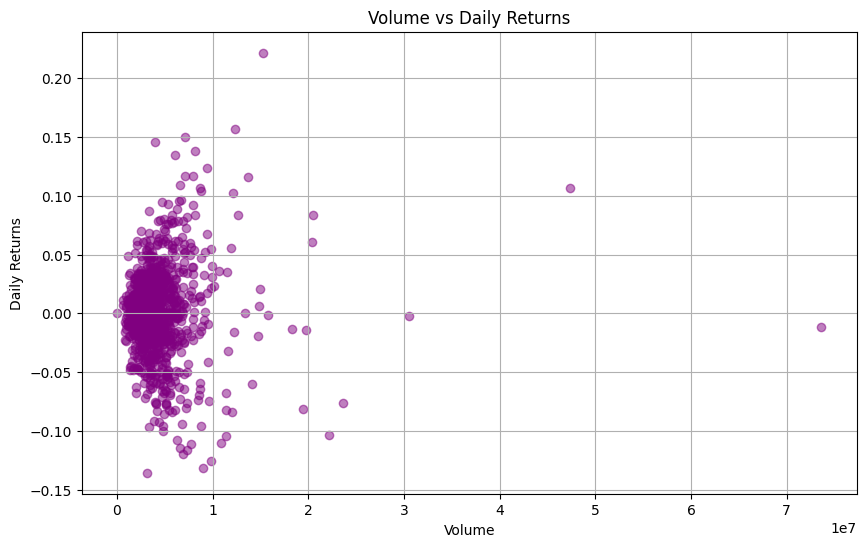

In [45]:
def plot_volume_returns_scatter(df):
    plt.figure(figsize=(10, 6))
    returns = df['Close'].pct_change()
    plt.scatter(df['Volume'], returns, alpha=0.5, color='purple')
    plt.title('Volume vs Daily Returns')
    plt.xlabel('Volume')
    plt.ylabel('Daily Returns')
    plt.grid(True)
    plt.show()

plot_volume_returns_scatter(df)

# Reporting and Recommendations

**Analyst 1**

The visualizations and data for DoorDash reveal several important insights  into the stock's behavior. The price chart with Bollinger Bands demonstrates that after a substantial decline and price swings from 2021 to mid-2022, DoorDash has experienced a robust and sustained recovery, reaching new highs by mid-2025. The narrowing and widening of the bands over time reflect periods of lower and higher volatility, respectively, and the most recent trend shows the price moving upward within the upper half of the bands, which is typically a bullish signal. The volume plot suggests that major price moves have coincided with spikes in trading activity, while the volatility plot indicates that although there are occasional surges in volatility, the overall trend since 2023 has been relatively stable suggesting market maturity, improved price discovery and reduced speculation.

The scatter plot of volume vs. daily returns shows that most trading days are concentrated around modest returns and moderate volumes, but with a few notable outliers where high volume coincides with larger price moves — this implies that significant events can drive both volatility and trading interest. Higher volumes often accompanying positive returns, suggesting stronger buying pressure. The distribution of log returns is centered around zero, with some fat tails, indicating the presence of both positive and negative outliers but an overall balance. **Recommendation:** For the firm to consider increasing its stake in DoorDash. The recent strong uptrend, stabilizing volatility, and healthy trading volumes suggest positive momentum and improving market sentiment. However, risk management remains important due to the potential for occasional sharp moves, so any position increase should be paired with cautious stop-loss strategies.

**Analyst 2**

As part of our due diligence on DoorDash, we conducted a comprehensive analysis of the company's stock performance from its IPO in late 2020 through June 2025. While volatility has been a consistent feature, our visual and statistical analysis suggests this volatility has largely been constructive rather than destabilising. The price has shown several rebounds after touching the lower Bollinger Band, often followed by sustained upward momentum, particularly when supported by a surge in trading volume, which is an indicator of strong market confidence.

The histogram of log returns reveals a return distribution with heavy positive tails, indicating DoorDash has experienced multiple days of outsized gains. At the meantime, the relationship between trading volume and daily return highlights frequent spikes in volume on high-return days. From a risk-return perspective, DoorDash demonstrates an attractive profile for a firm like ours that is open to strategic exposure. **Recommendation:** Based on this evidence, I recommend that we increase our stake in DoorDash, as the stock not only reflects strong historical resilience but also offers further upside potential.

**Analyst 3**

Plotting the technical indicator for Bollinger Bands showed a consistent relationship with the theory, as whenever the closing price (blue line) reached the upper bound (gray dash line), it was followed by sharp drops in the stock price, and vice versa when it reached the lower bound (red dash line), with upward movement in the price. These price changes were much more visible in the earlier periods of the data (Pre Q2 - 2022), when the volatility (3rd graph) of the stock was much higher. This is consistent when comparing with the later periods when DASH entered in a bullish market, and the closing price did not jump too far away from the simple moving average line (in yellow). Furthermore, we can use the plotted log returns in the histogram table, to see a typical bell shape curve, with the returns remaining around zero on average. This showcases that the overall commutative return would have also be close to zero and not exponentially growing. Furthermore, when visualising the daily returns with volume, we can see somewhat clustered data points around the low returns and low volume, excluding some outliers. This `looks` shows a low coloration between the two variables, meaning that high returns were not accommodated with high volume and vice versa. 

Looking at the Bollinger graph, we can see that the current signal suggests that the stock is not an attractive buy, as the closing price has touched the upper Bollinger Band, historically has preceded downward price movements. This presents an opportunity to open a short position, with an exit once the closing price line reaches the lower band. Moreover, the overall volatility of Dash has decreased compared to the earlier part of the dataset, suggesting that this downturn movement in the price will be short-lived while the overall trend of the simple moving average suggest for possible potential bearish trend forming. **Recommendation:** Given the consistency observed in the Bollinger Band signals it would likely have outperformed a simple buy-and-hold approach, which, according to the return histogram, would have delivered near-zero cumulative gains. However, this can be improved further if the company backtests other strategies which could be even more useful such as using fast and slow moving average crossovers, as this may help capture trends more dynamically and enhance returns.


**Analyst 4**

Our analysis of DASH from its IPO through mid-2025 reveals a stock that has evolved from high early-stage volatility into a more stable and predictable asset. While there were sharp fluctuations such as a 13.5% decline in February 2021 and a 22.1% surge in May, the overall distribution of log returns shows moderate fat tails with no persistent skew towards gains or losses. Rolling volatility peaked at 1.30 in June 2022 but steadily declined to 0.54 by early 2024, suggesting that investor sentiment has stabilised and market risk has diminished over time. Technical indicators such as the 20-day SMA and Bollinger Bands show that the stock has recently traded within expected bounds, with lower volatility clustering around mean values.

Although our scatter plot indicates that trading volume alone does not directly determine daily returns, there are meaningful exceptions such as March 2025, when a record 73.6 million shares traded coincided with a 13.8% price increase, suggesting volume can act as a leading signal in specific contexts. As the stock matures, these dynamics point to DASH becoming increasingly attractive from a risk-adjusted perspective. **Recommendation:** The firm to moderately increases its stake, adopting a phased investment strategy over 1–2 months to hedge against short-term volatility while taking advantage of longer-term upside potential.

**Analyst 5**

As the firm’s data analysis team, we have observed that DoorDash’s share price since its late-2020 listing has exhibited a series of well-ordered pullbacks and recoveries within its 20-day SMA and Bollinger Band framework. Notably, each test of the lower band has reliably marked a value zone, sparking multi-week rebounds that coincide with spikes in daily turnover, indicating renewed investor conviction rather than panicked selling. Our histogram of log returns further confirms a distribution skewed toward outsized positive moves, underscoring that upside rallies have outpaced downside shocks over the period.

**Recommendation:** Based on these technical and volume-based signals, as well as considering DoorDash’s proven ability to absorb volatility without breaking trend, we recommend tactically increasing our stake in the company. Specifically, I would phase in additional capital on systematic retracements to the lower Bollinger Band, while enforcing strict position limits to contain risk should volatility re-intensify. This disciplined, pullback-driven approach enables us to benefit from DoorDash’s demonstrated resilience and upside potential without compromising the overall stability of our portfolio.

**Analyst 6**

Although DoorDash’s recent price action shows positive momentum, with the price currently trading above the 20-day SMA and near the upper Bollinger Band (with a breakthrough recently), I still believe caution is necessary. According to the MACS (Moving Average Crossover Strategy), this crossover would typically imply a buy signal. However, although at moderate level now, the stock shows relatively high volatility in the past years (~0.03 – 0.08), including large volume surges (e.g., 73.6M shares on 2025-03-21) which have not consistently aligned with price gains. Furthermore, it has seen several strong daily price drops, including a -13.55% loss in 2021 and further ones in subsequent years. 

Additionally, the distribution of log returns is left-skewed, which suggests that negative daily returns are more frequent and higher. While the recent closing price of $218.12 (mid 2025) demonstrates a significant recovery from the 2022 lows (~$49), past patterns (such as in 2021 and 2022) show that price surges are often followed by major corrections. **Recommendation:** Therefore, despite technical indicators which imply short-term strength, I would currently not recommend increasing the steak in the firm, due to the combination of asymmetric downside risk of returns, relatively high volatility and unreliable volume dynamics.